In [17]:
import pandas as pd  

df = pd.read_excel("./dataset/golongan-ab-2012-2023.xlsx")

df['time'] = pd.to_datetime(df['time'], format='%Y-%m')

df.set_index('time', inplace=True)

df.index = df.index.to_period('M').to_timestamp('M')
df = df.asfreq('ME')

df['month'] = df.index.month
df['count'] = df.groupby('month')['count'].transform(lambda x: x.fillna(x.mean()))
df = df.drop(columns='month')

train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size].copy(), df.iloc[train_size:].copy()

print(test.head())

            count
time             
2021-08-31   79.0
2021-09-30   84.0
2021-10-31   80.0
2021-11-30   75.0
2021-12-31  129.0


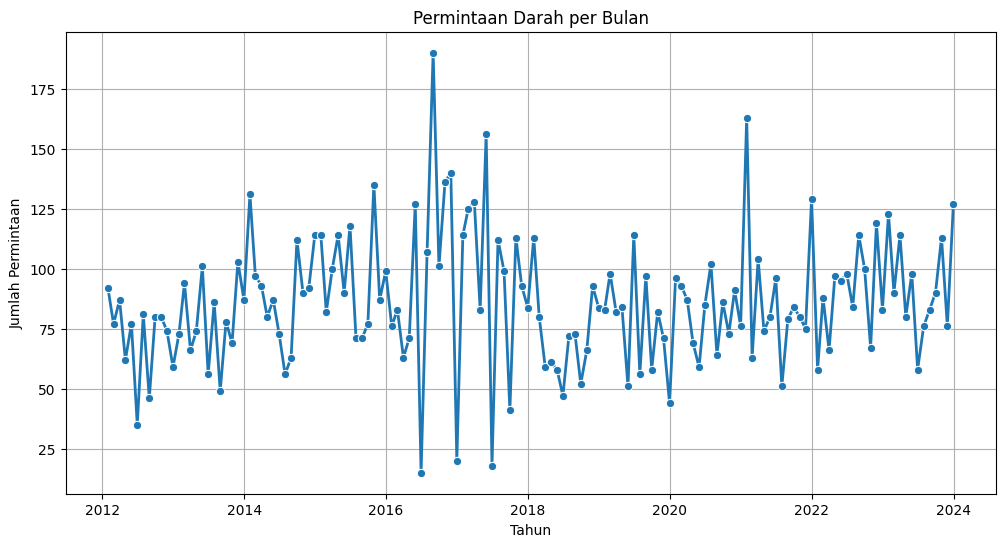

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot data time series
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x=df.index, y="count", marker="o", linewidth=2)
plt.title("Permintaan Darah per Bulan")
plt.xlabel("Tahun")
plt.ylabel("Jumlah Permintaan")
plt.grid()
plt.show()


In [19]:
from statsmodels.tsa.stattools import adfuller

# Uji stasioneritas dengan ADF Test
adf_test = adfuller(train['count'])
print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")

# Jika p-value < 0.05, data sudah stasioner

if adf_test[1] < 0.05:
    print("✅ Data training sudah stasioner (p-value < 0.05)")
else:
    print("⚠ Data training tidak stasioner (p-value >= 0.05), perlu differencing")


ADF Statistic: -3.3440220193389987
p-value: 0.013021764194510739
✅ Data training sudah stasioner (p-value < 0.05)


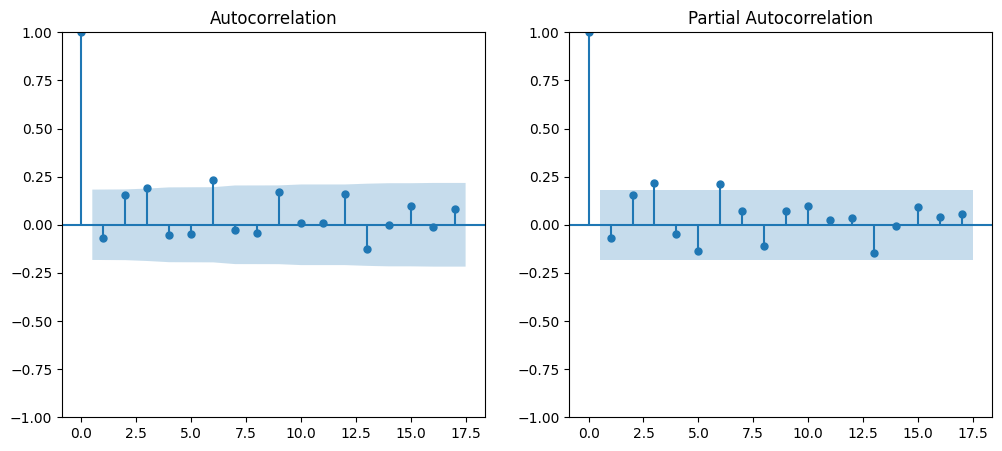

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12,5))
plt.subplot(121)
plot_acf(train.dropna(), lags=17, ax=plt.gca())  # ACF Plot
plt.subplot(122)
plot_pacf(train.dropna(), lags=17, ax=plt.gca())  # PACF Plot
plt.show()

In [28]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train['count'], order=(1,0,1))
fit_model = model.fit()


In [29]:
print(fit_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  count   No. Observations:                  115
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -545.304
Date:                Wed, 07 May 2025   AIC                           1098.609
Time:                        14:52:07   BIC                           1109.588
Sample:                    01-31-2012   HQIC                          1103.065
                         - 07-31-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         84.1173      4.726     17.801      0.000      74.856      93.379
ar.L1          0.9094      0.179      5.077      0.000       0.558       1.260
ma.L1         -0.8583      0.220     -3.894      0.0

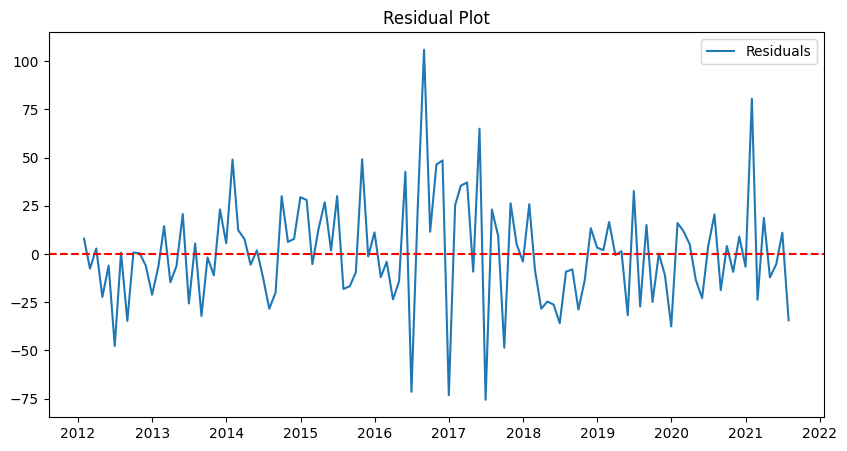

In [30]:
# === 5. Plot Residual untuk Evaluasi ===
plt.figure(figsize=(10,5))
plt.plot(fit_model.resid, label="Residuals")
plt.axhline(0, linestyle='--', color='red')
plt.title("Residual Plot")
plt.legend()
plt.show()

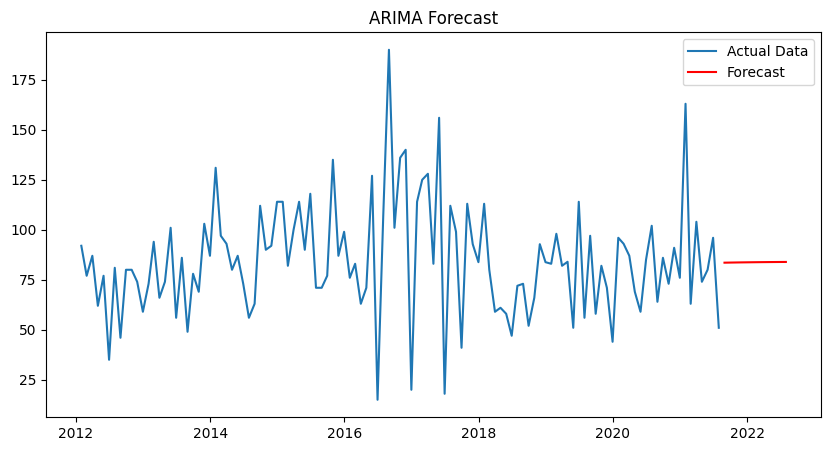

In [31]:
# === 6. Prediksi ke Depan ===
forecast = fit_model.forecast(steps=12)  # Prediksi 12 bulan ke depan
plt.figure(figsize=(10,5))
plt.plot(train['count'], label="Actual Data")
plt.plot(pd.date_range(train.index[-1], periods=13, freq='ME')[1:], forecast, label="Forecast", color='red')
plt.title("ARIMA Forecast")
plt.legend()
plt.show()

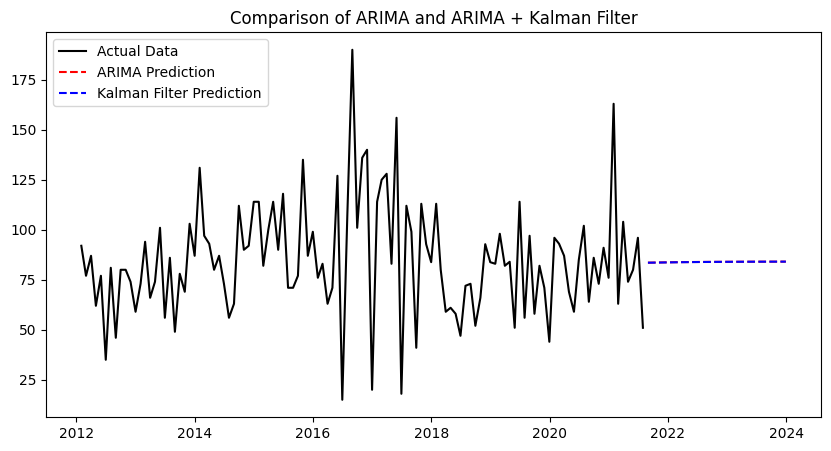

In [32]:
pred_arima = fit_model.predict(start=test.index[0], end=test.index[-1])

import numpy as np
from pykalman import KalmanFilter

# === 4. Setup Kalman Filter ===
kf = KalmanFilter(
    initial_state_mean=pred_arima.iloc[0],   # Estimasi awal dari ARIMA
    n_dim_obs=1,  # Data 1 dimensi (jumlah permintaan darah)
    n_dim_state=1,  # Model 1 state (prediksi jumlah darah)
    transition_matrices=[1],  # Asumsi model transisi sederhana
    observation_matrices=[1],  # Hubungan antara state dan observasi
    transition_covariance=np.eye(1) * 0.2,  # Covariance proses
    observation_covariance=np.eye(1)  * 0.5,  # Covariance observasi
    initial_state_covariance=np.eye(1) * 0.1
)

# === 5. Gunakan Kalman Filter untuk Update Prediksi ===
kf_state_means, kf_state_covariances = kf.filter(pred_arima.values)
kf_predictions = pd.Series(kf_state_means.flatten(), index=test.index)

# === 6. Plot Perbandingan ===
plt.figure(figsize=(10,5))
plt.plot(train['count'], label="Actual Data", color='black')
plt.plot(pred_arima, label="ARIMA Prediction", linestyle="dashed", color='red')
plt.plot(kf_predictions, label="Kalman Filter Prediction", linestyle="dashed", color='blue')
plt.legend()
plt.title("Comparison of ARIMA and ARIMA + Kalman Filter")
plt.show()

In [33]:
from sklearn.metrics import mean_absolute_percentage_error

# MAPE
mape_arima = mean_absolute_percentage_error(test['count'], pred_arima) * 100
mape_kf = mean_absolute_percentage_error(test['count'], kf_predictions) * 100

# === 7. Print Hasil Evaluasi ===
print(f"MAPE ARIMA: {mape_arima:.2f}%")
print(f"MAPE ARIMA + Kalman Filter: {mape_kf:.2f}%")

MAPE ARIMA: 16.87%
MAPE ARIMA + Kalman Filter: 16.87%


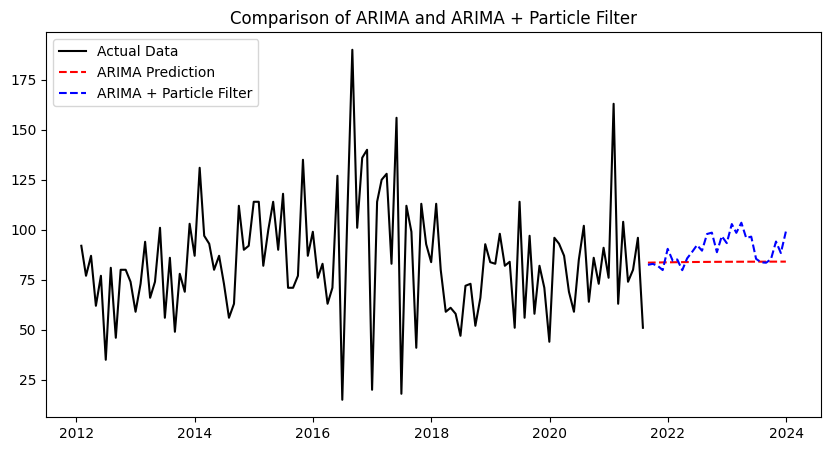

MAPE ARIMA: 16.87%
MAPE ARIMA + Particle Filter: 13.74%


In [34]:
from filterpy.monte_carlo import systematic_resample
from scipy.stats import norm

class ParticleFilter:
    def __init__(self, num_particles=1000, process_noise=1.0, obs_noise=5.0):
        self.num_particles = num_particles
        self.process_noise = process_noise
        self.obs_noise = obs_noise
        self.particles = np.random.normal(loc=pred_arima.iloc[0], scale=process_noise, size=num_particles)
        self.weights = np.ones(num_particles) / num_particles

    def predict(self):
        # Simpan noise kecil dalam transisi partikel
        self.particles += np.random.normal(0, self.process_noise, size=self.num_particles)

    def update(self, measurement):
        # Hitung probabilitas Gaussian berdasarkan observasi
        likelihood = norm.pdf(self.particles, loc=measurement, scale=self.obs_noise)
        self.weights *= likelihood
        self.weights += 1.e-300  # Hindari pembagian nol
        self.weights /= np.sum(self.weights)  # Normalisasi bobot

    def resample(self):
        indices = systematic_resample(self.weights)
        self.particles = self.particles[indices]
        self.weights.fill(1.0 / self.num_particles)

    def estimate(self):
        return np.mean(self.particles)

# === 5. Run Particle Filter on ARIMA Predictions ===
pf = ParticleFilter(num_particles=1000, process_noise=2.0, obs_noise=5.0)
pf_predictions = []

for i in range(len(test)):
    pf.predict()
    pf.update(test.values[i])
    pf.resample()
    pf_predictions.append(pf.estimate())

pf_predictions = pd.Series(pf_predictions, index=test.index)

# === 6. Plot Perbandingan ARIMA vs ARIMA + PF ===
plt.figure(figsize=(10, 5))
plt.plot(train['count'], label="Actual Data", color='black')
plt.plot(pred_arima, label="ARIMA Prediction", linestyle="dashed", color='red')
plt.plot(pf_predictions, label="ARIMA + Particle Filter", linestyle="dashed", color='blue')
plt.legend()
plt.title("Comparison of ARIMA and ARIMA + Particle Filter")
plt.show()

# === 7. Evaluasi Model (MAPE) ===
mape_arima = mean_absolute_percentage_error(test['count'], pred_arima) * 100
mape_pf = mean_absolute_percentage_error(test['count'], pf_predictions) * 100

print(f"MAPE ARIMA: {mape_arima:.2f}%")
print(f"MAPE ARIMA + Particle Filter: {mape_pf:.2f}%")